# Medical Text Data Modelling

**Author:**
- Carlos Salgado - [email](mailto:csalgado@uwo.ca) | [GitHub](https://github.com/socd06) | [LinkedIn](www.linkedin.com/in/eng-socd)

## Problem Statement
Bob <sup>MD</sup> and Alice <sup>MD</sup> are physicians running their respective medical practices and both have a database of private medical transcriptions. You own a Natural Language Processing (NLP) company and have been contacted by these physicians because both Bob <sup>MD</sup> and Alice <sup>MD</sup> have heard of the high quality of the Machine Learning as a Service (MLaaS) solutions you provide and want you to create a text classifier to help them automatically assign a medical specialty to each new patient text transcription.

## Limitations

Healthcare data is highly regulated and should be, for most intents and purposes, private. Therefore, if in a medical setting, the Machine Learning model being trained should not actually look at the data. 

Combining both Bob's and Alice's datasets, you should be able to create a bigger, better dataset that you could use to train your model with higher accuracy, only that you can't because it's all sensitive and private data, which is why you will need [PySyft](https://github.com/OpenMined/pysyft/) and [SyferText](https://github.com/OpenMined/SyferText/) to complete the job at hand.

## Data Exploration and Feature Engineering
We will take advantage of this simulated dataset, since it is not a real-life scenario, we can and will be able to do data exploration to determine the best way to tackle the problem. 

Verifying requirements and installing if missing. 

In [1]:
!pip install -r ../requirements.txt

## Data Exploration
Assuming you have access to the the anonymized combined data, you can do a very high-level data exploration in order to design the text classifier for the job. 

In [2]:
# Reading dataset
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
df = pd.read_csv('../data/mtsamples.csv', delimiter=',')
df.dataframeName = 'mtsamples.csv'

In [3]:
# Taking a quick look at what the data looks like
df.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


## Dealing with Missing Data
We want to use the `transcription` column as part of our training data so we need to check if the column (or any other one) has blanks

In [4]:
df.isnull().sum(axis = 0)

Unnamed: 0              0
description             0
medical_specialty       0
sample_name             0
transcription          33
keywords             1068
dtype: int64

We have confirmed there are 33 blanks in our column of interest but there is information in every other column except for the `keywords` column. To fix the issue, we will fill the transcription blanks with the `description` column which should have some keywords in it, allowing us to still train without removing these datapoints.

In [5]:
df['transcription'].fillna(df['description'], inplace=True)

Now we can start our exploration, beginning with listing how many different specialties there are

In [6]:
# And how many different ones
len(df['medical_specialty'].unique())

40

and what each specialty frequencies is

In [7]:
df['medical_specialty'].value_counts()

 Surgery                          1103
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        372
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  230
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Obstetrics / Gynecology           160
 Urology                           158
 Discharge Summary                 108
 ENT - Otolaryngology               98
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    62
 Psychiatry / Psychology            53
 Office Notes                       51
 Podiatry                           47
 Dermatology                        29
 Cosmetic / Plastic Surgery         27
 Dentistry               

## Data Visualization and Normality Testing
Next, we will use `matplotlib` and `seaborn` to plot and visualize the dataset. We will also calculate the `skewness` and `kurtosis` of our dataset to determine how normal our distribution is.

**Reference:**
- [GoodData.com: Normality Testing - Skewness and Kurtosis
](https://help.gooddata.com/doc/en/reporting-and-dashboards/maql-analytical-query-language/maql-expression-reference/aggregation-functions/statistical-functions/predictive-statistical-use-cases/normality-testing-skewness-and-kurtosis#:~:text=As%20a%20general%20rule%20of,the%20distribution%20is%20approximately%20symmetric.)

In [8]:
import matplotlib.pyplot as plt
import seaborn as sb

sb.set()

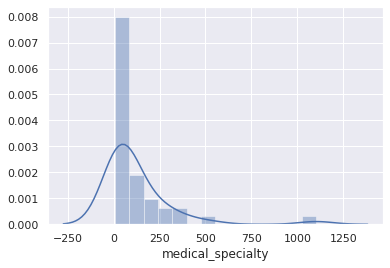

In [9]:
# Plotting the distribution 
sb.distplot(df['medical_specialty'].value_counts());

We have a non-normal distribution, now we will double check testing by skewness and kurtosis

In [10]:
# we define a normality testing function that uses skewness and kurtosis
def normality_testing(sk, kt):
    sk = round(sk,3)
    kt = round(kt,3)
    if kt > 0:
        print("positive kurtosis =",kt) 
    else:
        print("negative kurtosis (less normal) = ",kt) 
    
    if abs(sk) > 1:
        print("skewness =",sk,"\nThe distribution is highly skewed")
    elif abs(sk >= 0.5):
        print("skewness =",sk,"\nThe distribution is moderately skewed")
    else:
        print("skewness =",sk,"\nThe distribution is approximately symmetric")
    
    

In [11]:
skewness = df['medical_specialty'].value_counts().skew()
kurtosis = df['medical_specialty'].value_counts().kurt()

normality_testing(skewness,kurtosis)

positive kurtosis = 15.336
skewness = 3.516 
The distribution is highly skewed


And a highly skewed distribution with positive kurtosis. 
Next, we will plot to visualize the value counts in a more helpful

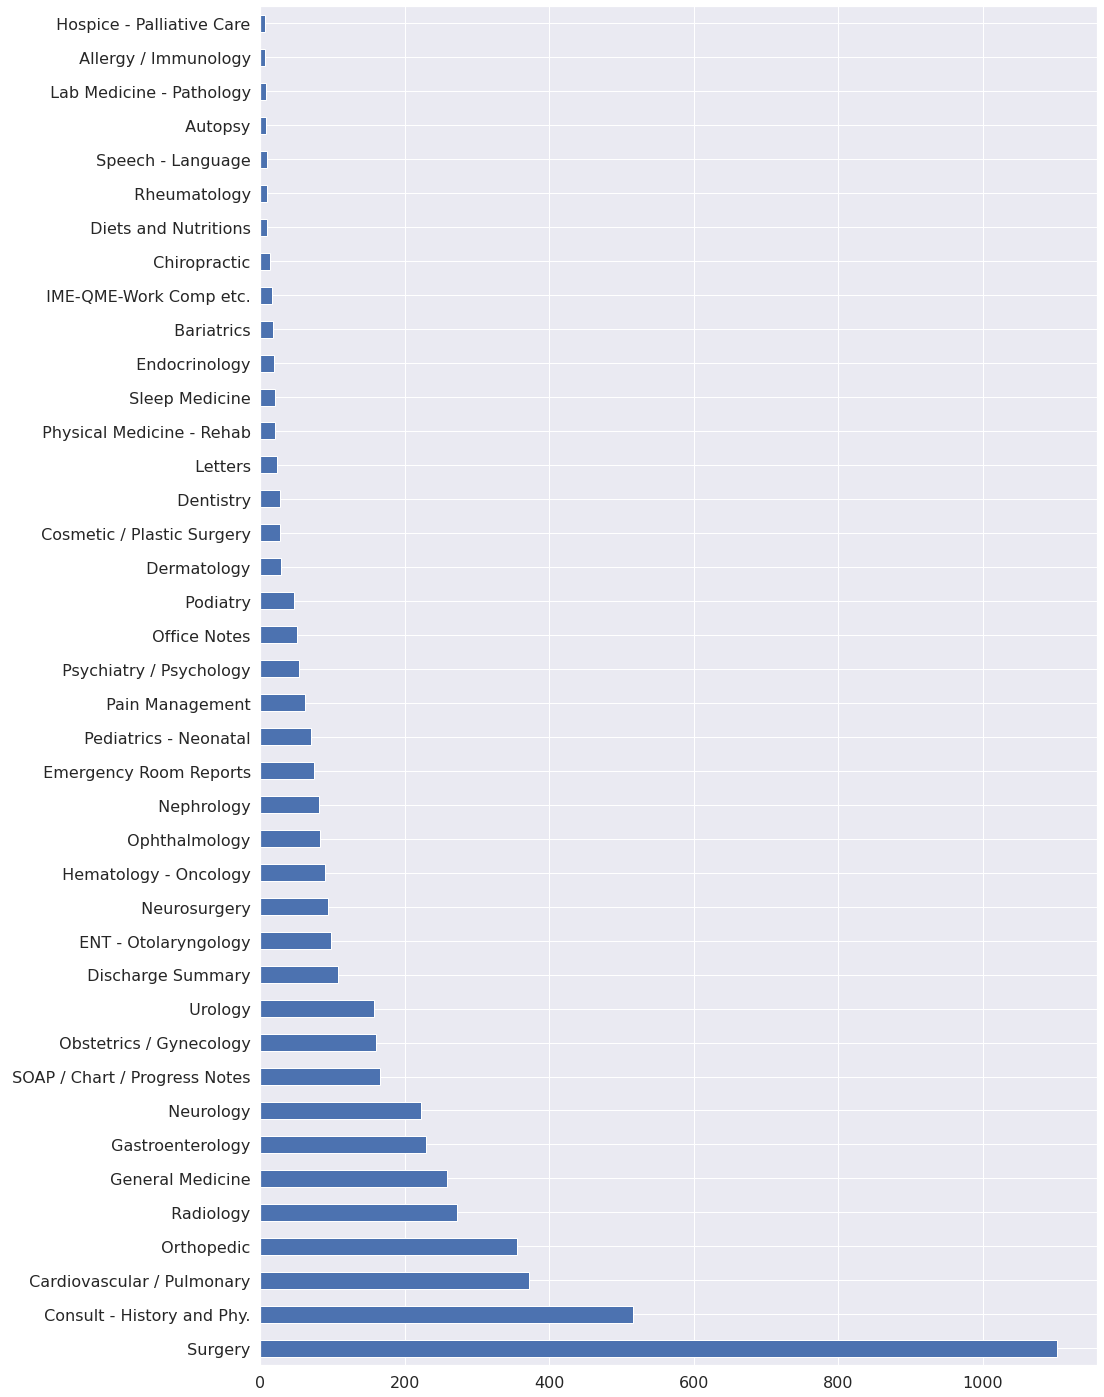

In [12]:
df['medical_specialty'].value_counts()[:40].plot(kind='barh', figsize=(15,25), fontsize=16)


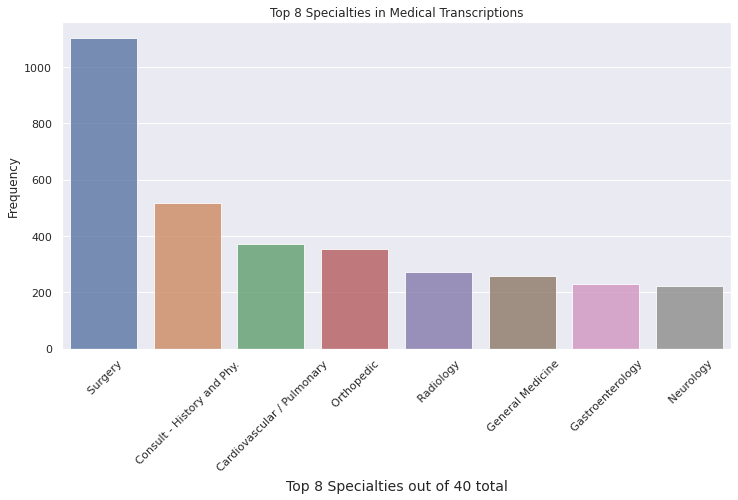

In [13]:
# Display the top specialties most frequently repeated in the text
fig, ax = plt.subplots(figsize = (12,6)) # set size of figure
specialty = df['medical_specialty'].value_counts()
specialty = specialty[:8,]
g = sb.barplot(specialty.index, specialty.values, alpha=0.8)

plt.title("Top 8 Specialties in Medical Transcriptions")
plt.ylabel("Frequency", fontsize=12)
plt.xlabel("Top 8 Specialties out of 40 total", fontsize=14)

g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.show()

We clearly need to work on our dataset since it is heavyly skewed towards `Surgery` and it won't be a very useful as training data with such a distribution. 

## Feature Engineering
We will first clean up the medical specialty column of first character whitespaces.

In [14]:
feature = 'medical_specialty'
df[feature] = df[feature].str.replace(r'\A ', '')
df.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


## Dimensionality Reduction

We now know we have too many possible labels. A good data set will have 4 or 5 labels and a lot more data points so we need to reduce the number of classes. Luckily, we can group our classes using the [ultimate list of medical specialties](https://www.sgu.edu/blog/medical/ultimate-list-of-medical-specialties/) as a guide to reduce the number of classes. The downside is we will need to do some reading before we reconfigure our features.

Renaming some specialties to reduce categories, starting in the same order as the list.

In [15]:
# renaming specialties under Anesthesiology and Internal Medicine
new_class = 'Internal Medicine'
# Grouping all anesthesiology specialties
df[feature].mask(df[feature] == 'Hospice - Palliative Care', new_class, inplace=True)
df[feature].mask(df[feature] == 'Pain Management', new_class, inplace=True)
df[feature].mask(df[feature] == 'Sleep Medicine', new_class, inplace=True)
df[feature].mask(df[feature] == 'Endocrinology', new_class, inplace=True)
df[feature].mask(df[feature] == 'Gastroenterology', new_class, inplace=True)
df[feature].mask(df[feature] == 'Hematology - Oncology', new_class, inplace=True)
df[feature].mask(df[feature] == 'Nephrology', new_class, inplace=True)
df[feature].mask(df[feature] == 'Rheumatology', new_class, inplace=True)
df[feature].mask(df[feature] == 'Cardiovascular / Pulmonary', new_class, inplace=True)
# General medicine is also known as Internal Medicine
df[feature].mask(df[feature] == 'General Medicine', new_class, inplace=True)

print("Reduced",feature,"to",len(df[feature].unique()),"total classes")

Reduced medical_specialty to 31 total classes


In [16]:
new_class = 'Surgery'
# Grouping all surgery specialties
df[feature].mask(df[feature] == 'Surgery', new_class, inplace=True)
df[feature].mask(df[feature] == 'Cosmetic / Plastic Surgery', new_class, inplace=True)
df[feature].mask(df[feature] == 'Neurosurgery', new_class, inplace=True)
df[feature].mask(df[feature] == 'ENT - Otolaryngology', new_class, inplace=True)
df[feature].mask(df[feature] == 'Obstetrics / Gynecology', new_class, inplace=True)
df[feature].mask(df[feature] == 'Urology', new_class, inplace=True)

print("Reduced",feature,"to",len(df[feature].unique()),"total classes")

Reduced medical_specialty to 26 total classes


In [17]:
new_class = 'Medical Records'
# Grouping all documents
df[feature].mask(df[feature] == 'Consult - History and Phy.', new_class, inplace=True)
df[feature].mask(df[feature] == 'Discharge Summary', new_class, inplace=True)
df[feature].mask(df[feature] == 'Emergency Room Reports', new_class, inplace=True)
df[feature].mask(df[feature] == 'IME-QME-Work Comp etc.', new_class, inplace=True)
df[feature].mask(df[feature] == 'Letters', new_class, inplace=True)
df[feature].mask(df[feature] == 'Office Notes', new_class, inplace=True)
df[feature].mask(df[feature] == 'SOAP / Chart / Progress Notes', new_class, inplace=True)
df[feature].mask(df[feature] == 'Radiology', new_class, inplace=True)

print("Reduced",feature,"to",len(df[feature].unique()),"total classes")

Reduced medical_specialty to 19 total classes


In [18]:
new_class = 'Other' 
# Grouping less popular specialties and specialties with the least data points
df[feature].mask(df[feature] == 'Diets and Nutritions', new_class, inplace=True)
df[feature].mask(df[feature] == 'Bariatrics', new_class, inplace=True)
df[feature].mask(df[feature] == 'Dentistry', new_class, inplace=True)
df[feature].mask(df[feature] == 'Ophthalmology', new_class, inplace=True)
df[feature].mask(df[feature] == 'Pediatrics - Neonatal', new_class, inplace=True)
df[feature].mask(df[feature] == 'Dermatology', new_class, inplace=True)
df[feature].mask(df[feature] == 'Allergy / Immunology', new_class, inplace=True)
df[feature].mask(df[feature] == 'Speech - Language', new_class, inplace=True)
df[feature].mask(df[feature] == 'Psychiatry / Psychology', new_class, inplace=True)
df[feature].mask(df[feature] == 'Autopsy', new_class, inplace=True)
df[feature].mask(df[feature] == 'Lab Medicine - Pathology', new_class, inplace=True)
df[feature].mask(df[feature] == 'Physical Medicine - Rehab', new_class, inplace=True)
df[feature].mask(df[feature] == 'Orthopedic', new_class, inplace=True)
df[feature].mask(df[feature] == 'Chiropractic', new_class, inplace=True)
df[feature].mask(df[feature] == 'Podiatry', new_class, inplace=True)
df[feature].mask(df[feature] == 'Neurology', new_class, inplace=True)

print("Reduced",feature,"to",len(df[feature].unique()),"total classes")

Reduced medical_specialty to 4 total classes


In [19]:
# Double checking what the classes are
df['medical_specialty'].unique()

array(['Other', 'Internal Medicine', 'Surgery', 'Medical Records'],
      dtype=object)

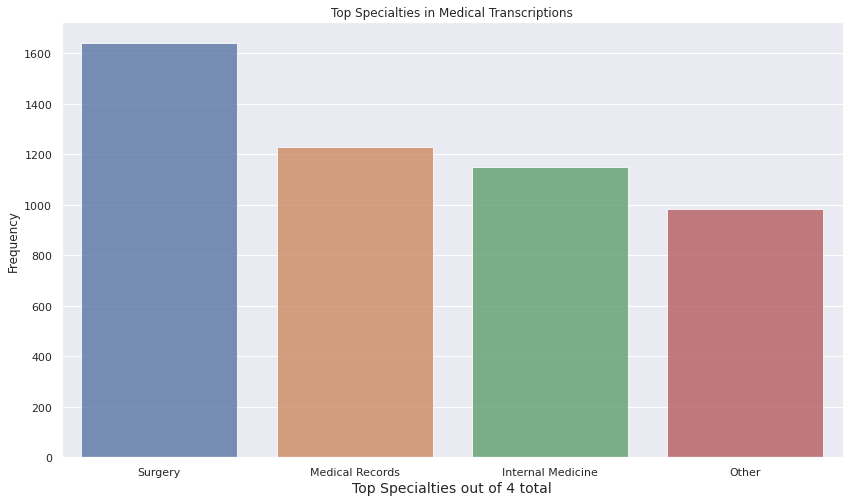

In [20]:
# Display the consolidated 4 specialties most frequently repeated in the text
fig, ax = plt.subplots(figsize = (14,8)) # set size of figure
specialty = df['medical_specialty'].value_counts()
specialty = specialty[::,]
g = sb.barplot(specialty.index, specialty.values, alpha=0.8)

# Calculate total classes
total = str(len(df['medical_specialty'].unique()))
plt.title("Top Specialties in Medical Transcriptions")
plt.ylabel("Frequency", fontsize=12)

x_label_str = "Top Specialties out of " + total +" total"
plt.xlabel(x_label_str, fontsize=14)

g.set_xticklabels(g.get_xticklabels(), rotation=0)

plt.show()

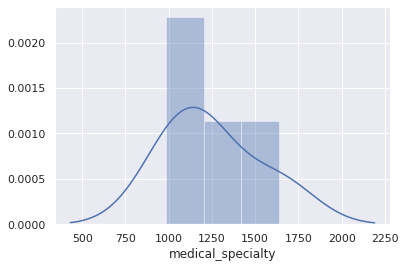

In [21]:
sb.distplot(df['medical_specialty'].value_counts());

In [22]:
skewness = df['medical_specialty'].value_counts().skew()
kurtosis = df['medical_specialty'].value_counts().kurt()

normality_testing(skewness,kurtosis)

positive kurtosis = 1.999
skewness = 1.195 
The distribution is highly skewed


We still have skewed data but the resulting distribution is way more normal now.

## Creating the Classes file
First, we make a dictionary with the specialties as values and the chosen encodings as keys

In [23]:
keys = [3,2,4,1]
values = sorted(df['medical_specialty'].unique())
zipObj = zip(keys,values)
classes_dict = dict(zipObj)
classes_dict

{3: 'Internal Medicine', 2: 'Medical Records', 4: 'Other', 1: 'Surgery'}

In [24]:
classes_dict = sorted(classes_dict.items())
#sort_orders = sorted(orders.items(), key=lambda x: x[1], reverse=True)
classes_dict = dict(classes_dict)

Then we order by frequency and save the classes.txt file

In [25]:
classes_dict

{1: 'Surgery', 2: 'Medical Records', 3: 'Internal Medicine', 4: 'Other'}

In [26]:
classes_file = open("../data/classes.txt","w") 
for i in classes_dict:
    classes_file.write(classes_dict[i]) 
    classes_file.write("\n")

classes_file.close()

## Consolidating standardized dataset
First, we make a copy of the current dataframe. Then, we add the `keywords` column to the `transcription` column,  and lastly, we substitute the labels with their encodings and save the final files.

In [27]:
# Choosing features (columns)
features = ['medical_specialty','sample_name','transcription','keywords']

# X is the standard training  data variable name 
X = df[features]
X.head()

,medical_specialty,sample_name,transcription,keywords
0,Other,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,Other,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,Other,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,Internal Medicine,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,Internal Medicine,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


We are aware there are blanks in the `keywords` column, so we will treat it as a string and merge it with the transcription column to have more keywords in our training data.

In [28]:
# Checking blank values
X.isnull().sum(axis = 0)

medical_specialty       0
sample_name             0
transcription           0
keywords             1068
dtype: int64

In [29]:
# Merging columns
X['text'] = X['transcription'] + X['keywords'].astype(str)


# Verifying our operation
X.head()

/home/carlos/anaconda3/envs/syft/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,medical_specialty,sample_name,transcription,keywords,text
0,Other,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller...","SUBJECTIVE:, This 23-year-old white female pr..."
1,Other,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh...","PAST MEDICAL HISTORY:, He has difficulty climb..."
2,Other,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart...","HISTORY OF PRESENT ILLNESS: , I have seen ABC ..."
3,Internal Medicine,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple...","2-D M-MODE: , ,1. Left atrial enlargement wit..."
4,Internal Medicine,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo...",1. The left ventricular cavity size and wall ...


In [30]:
# Then we will drop the original columns
X = X.drop(['transcription', 'keywords'], axis=1)

# Verifying
X.head()

,medical_specialty,sample_name,text
0,Other,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr..."
1,Other,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb..."
2,Other,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ..."
3,Internal Medicine,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
4,Internal Medicine,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...


In [31]:
# And confirm there are no blanks
X.isnull().sum(axis = 0)

medical_specialty    0
sample_name          0
text                 0
dtype: int64

In [32]:
# Replacing labels by their numeric encodings
# add for loop
for key in classes_dict.keys():
    X.loc[(X['medical_specialty'] == classes_dict[key]),'medical_specialty']=key

In [33]:
# Verifying it worked
X.head()

,medical_specialty,sample_name,text
0,4,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr..."
1,4,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb..."
2,4,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ..."
3,3,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
4,3,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...


In [34]:
# Renaming columns to standard dataset names
X = X.rename(columns={"medical_specialty": "label", "sample_name": "description"})
X.head()

,label,description,text
0,4,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr..."
1,4,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb..."
2,4,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ..."
3,3,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
4,3,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...


Saving the full new dataframe into a Comma Separated Values (*.csv) file

In [36]:
X.to_csv('../data/X.csv', index = False)

Lastly, we split the dataset into training and test datasets using sklearn's `train_test_split` at a 90/10 rate and we save the final files.

In [37]:
# importing sklearn's train_test_split
from sklearn.model_selection import train_test_split

# Generating the 90/10 split 
X_train, X_test = train_test_split(X, test_size=0.1)

# And saving the train and test subsets into csv files
X_train.to_csv('../data/train.csv', index = False)
X_test.to_csv('../data/test.csv', index = False)